In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../assets/data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

# Lecture 21

## Randomized Controlled Experiment ##

In [2]:
rct = Table.read_table('bta.csv')
rct.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [3]:
rct.pivot('Result', 'Group')

Group,0.0,1.0
Control,14,2
Treatment,6,9


In [4]:
rct.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


In [5]:
observed_outcomes = Table.read_table('observed_outcomes.csv')
observed_outcomes.show()

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


## Test Statistic ##

potential treatment proportion - potential control proportion

In [6]:
group_proportions = rct.group('Group', np.average).column(1)
group_proportions

array([ 0.125,  0.6  ])

In [7]:
group_proportions.item(1) - group_proportions.item(0)

0.475

## Simulating the Statistic Under the Null ##

In [8]:
shuffled_labels = rct.sample(with_replacement=False).column('Group')

In [9]:
original_and_shuffled = rct.with_column('Shuffled Label', shuffled_labels)
original_and_shuffled

Group,Result,Shuffled Label
Control,1,Treatment
Control,1,Control
Control,0,Treatment
Control,0,Treatment
Control,0,Control
Control,0,Treatment
Control,0,Control
Control,0,Control
Control,0,Treatment
Control,0,Treatment


In [10]:
original_and_shuffled.select('Result', 'Group').group(
    'Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


In [11]:
original_and_shuffled.select('Result', 'Shuffled Label').group(
    'Shuffled Label', np.average)

Shuffled Label,Result average
Control,0.4375
Treatment,0.266667


In [12]:
def difference_of_proportions(table, group_label):
    """Takes: name of table,
    column label that indicates which group the row relates to
    Returns: Difference of proportions of 1's in the two groups"""
    
    # table with the two relevant columns
    reduced = table.select('Result', group_label)  
    
    # table containing group means
    proportions_table = reduced.group(group_label, np.average)
    
    # array of group means
    proportions = proportions_table.column('Result average')
    
    return proportions.item(1) - proportions.item(0)

In [13]:
observed_diff = difference_of_proportions(rct, 'Group')
observed_diff

0.475

In [14]:
def one_simulated_difference_of_proportions():
    """Returns: Difference of proportions of 1's
    of treatment and control groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = rct.sample(with_replacement=False).column('Group')
    
    # table of numerical variable and shuffled labels
    shuffled_table = rct.select('Result').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_proportions(shuffled_table, 'Shuffled Label')   

In [15]:
one_simulated_difference_of_proportions()

-0.17083333333333334

In [16]:
simulated_diffs = make_array()

for i in np.arange(20000):
    sim_diff = one_simulated_difference_of_proportions()
    simulated_diffs = np.append(simulated_diffs, sim_diff)

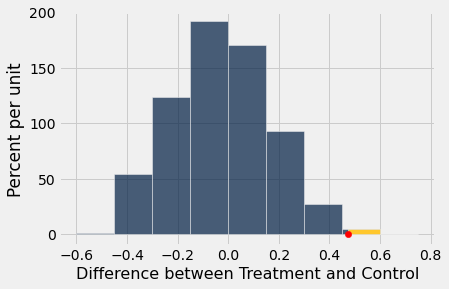

In [17]:
col_name = 'Difference between Treatment and Control'
Table().with_column(col_name, simulated_diffs).hist(
    bins=np.arange(-0.6, 0.81, 0.15), left_end=observed_diff)
plots.ylim(-0.1, 2)
plots.scatter(observed_diff, 0, color='red', s=40, zorder=3);

In [18]:
# p-value
sum(simulated_diffs >= observed_diff)/len(simulated_diffs)

0.0079500000000000005

## Discussion Question 1 ##

In [19]:
# One row per student
scores = Table.read_table('scores_by_section.csv').relabeled(1, 'Score')
scores

Section,Score
1,22
2,12
2,23
2,14
1,20
3,25
4,19
1,24
5,8
6,14


In [20]:
# max
max(scores.column('Score'))

25

In [21]:
# class average
np.average(scores.column('Score'))

15.493036211699165

In [22]:
section_counts = scores.group('Section')
section_counts.show()

Section,count
1,32
2,32
3,27
4,30
5,33
6,32
7,24
8,29
9,30
10,34


In [23]:
section_averages = scores.group('Section', np.average)
section_averages

Section,Score average
1,15.5938
2,15.125
3,13.6667
4,14.7667
5,17.4545
6,15.0312
7,16.625
8,16.3103
9,14.5667
10,15.2353


In [24]:
# section_data should have 3 columns:
# Section, count, and Score average
section_data = section_counts.join('Section', section_averages, 'Section')
section_data.show()

Section,count,Score average
1,32,15.5938
2,32,15.125
3,27,13.6667
4,30,14.7667
5,33,17.4545
6,32,15.0312
7,24,16.625
8,29,16.3103
9,30,14.5667
10,34,15.2353


Null Hypothesis:


Alternative Hypothesis:


Test Statistic:


For the p-value, we will start at ... and look to the ...

In [25]:
observed_average = 13.6667

In [26]:
def one_simulated_average():
    random_sample = scores.sample(27, with_replacement=False)
    return np.average(random_sample.column('Score'))

In [27]:
num_simulations = 50000
averages = make_array()
for i in np.arange(num_simulations):
    averages = np.append(averages, one_simulated_average())

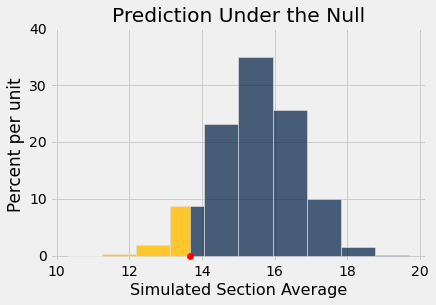

In [28]:
Table().with_column('Simulated Section Average', averages).hist(right_end=observed_average)
plots.ylim(-0.01, 0.4)
plots.scatter(observed_average, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null');

In [29]:
np.count_nonzero(averages <= observed_average)/num_simulations

0.05844

Conclusion: 

## Discussion Question 2 ##

Null Hypothesis:


Aternative Hypothesis:


Test Statistic:


For the p-value, start at ... and look to the ...

In [30]:
def simulate_one_count():
    return np.count_nonzero(np.random.choice(['H', 'T'], 200) == 'H')

In [31]:
num_simulations = 10000
counts = make_array()
for i in np.arange(num_simulations):
    counts = np.append(counts, simulate_one_count())

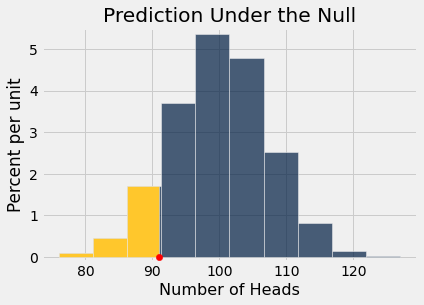

In [32]:
Table().with_column('Number of Heads', counts).hist(right_end=91)
plots.ylim(-0.001, 0.055)
plots.scatter(91, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null');

In [33]:
np.count_nonzero(counts <= 91)/10000

0.1151

Conclusion: 

## Discussion Question 3 ##

Null Hypothesis:


Aternative Hypothesis:


Test Statistic:


For the p-value, start at ... and look to the ...

In [34]:
wheel = make_array(18/38, 18/38, 2/38)

In [35]:
obs_counts = make_array(166, 186, 28)
obs_distribution = obs_counts / 380
obs_tvd = sum(abs(obs_distribution - wheel))/2
obs_tvd

0.036842105263157891

In [36]:
def simulate_one_tvd():
    sample_dist = sample_proportions(380, wheel)
    return sum(abs(sample_dist - wheel))/2

In [37]:
num_simulations = 10000
tvds = make_array()
for i in np.arange(10000):
    tvds = np.append(tvds, simulate_one_tvd())

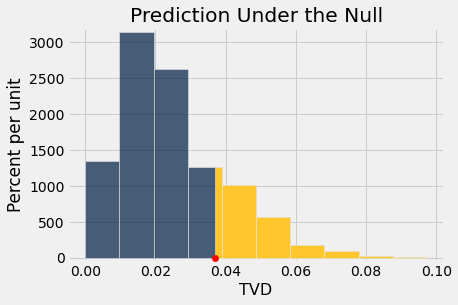

In [38]:
Table().with_column('TVD', tvds).hist(left_end=obs_tvd)
plots.ylim(-0.5, 32)
plots.scatter(obs_tvd, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null');

In [39]:
np.count_nonzero(tvds >= obs_tvd)/num_simulations

0.2077

Conclusion: 